In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xai-data/clinical_mastitis_cows.csv


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

2024-06-22 21:28:51.876415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 21:28:51.876552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 21:28:52.032205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the dataset
file_path = "/kaggle/input/xai-data/clinical_mastitis_cows.csv"  # Update with the correct path
df = pd.read_csv(file_path)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load dataset (assuming dataset is already loaded and boolean columns converted)

df = df.drop(columns=[ 'Day','Cow_ID','Milk_visibility'])
df = pd.get_dummies(df)

df

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,class1,Breed_Jersey,Breed_hostlene
0,1,0,150,180,150,180,150,181,150,181,43,0,0,0,True,False
1,1,0,152,180,152,185,151,180,152,181,42,0,0,0,True,False
2,1,0,152,182,153,186,151,186,153,183,41,0,0,0,True,False
3,1,0,155,183,155,189,155,182,155,186,40,0,0,0,True,False
4,1,0,150,186,150,181,150,185,150,188,41,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,5,0,243,285,310,361,241,285,246,281,43,1,0,1,True,False
6596,5,0,240,276,315,358,242,285,247,284,43,1,0,1,True,False
6597,5,0,242,286,315,365,237,279,248,288,43,1,0,1,True,False
6598,5,0,245,285,314,361,239,280,241,288,43,1,0,1,True,False


In [5]:
df['Breed_Jersey'] = df['Breed_Jersey'].apply(lambda x: 1 if x else 0)
df['Breed_hostlene'] = df['Breed_hostlene'].apply(lambda x: 1 if x else 0)


y = df['class1'].values


x = df.drop('class1', axis=1)
x.info()
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Months after giving birth  6600 non-null   int64
 1   Previous_Mastits_status    6600 non-null   int64
 2   IUFL                       6600 non-null   int64
 3   EUFL                       6600 non-null   int64
 4   IUFR                       6600 non-null   int64
 5   EUFR                       6600 non-null   int64
 6   IURL                       6600 non-null   int64
 7   EURL                       6600 non-null   int64
 8   IURR                       6600 non-null   int64
 9   EURR                       6600 non-null   int64
 10  Temperature                6600 non-null   int64
 11  Hardness                   6600 non-null   int64
 12  Pain                       6600 non-null   int64
 13  Breed_Jersey               6600 non-null   int64
 14  Breed_hostlene          

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,Breed_Jersey,Breed_hostlene
0,1,0,150,180,150,180,150,181,150,181,43,0,0,1,0
1,1,0,152,180,152,185,151,180,152,181,42,0,0,1,0
2,1,0,152,182,153,186,151,186,153,183,41,0,0,1,0
3,1,0,155,183,155,189,155,182,155,186,40,0,0,1,0
4,1,0,150,186,150,181,150,185,150,188,41,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,5,0,243,285,310,361,241,285,246,281,43,1,0,1,0
6596,5,0,240,276,315,358,242,285,247,284,43,1,0,1,0
6597,5,0,242,286,315,365,237,279,248,288,43,1,0,1,0
6598,5,0,245,285,314,361,239,280,241,288,43,1,0,1,0


In [6]:
# Split data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape[0], "or", round(X_train.shape[0]/x.shape[0]*100, 1), "%")
print("Test set size:", X_test.shape[0], "or", round(X_test.shape[0]/x.shape[0]*100, 1), "%")
print("Validation set size:", X_val.shape[0], "or", round(X_val.shape[0]/x.shape[0]*100, 1), "%")

Training set size: 4620 or 70.0 %
Test set size: 1326 or 20.1 %
Validation set size: 654 or 9.9 %


In [7]:
# Reshape the input data for LSTM (samples, time steps, features)
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, n_features))

X_val_reshaped

array([[[  5,   0, 160, ...,   0,   1,   0]],

       [[  1,   0, 243, ...,   0,   1,   0]],

       [[  3,   0, 160, ...,   0,   1,   0]],

       ...,

       [[  3,   0, 164, ...,   0,   1,   0]],

       [[  3,   0, 232, ...,   0,   1,   0]],

       [[  4,   0, 231, ...,   0,   1,   0]]])

In [8]:
# Define and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, n_features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7454 - loss: 0.5713 - val_accuracy: 0.8960 - val_loss: 0.3253
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9003 - loss: 0.3090 - val_accuracy: 0.8914 - val_loss: 0.3036
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9007 - loss: 0.3060 - val_accuracy: 0.8945 - val_loss: 0.3288
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8998 - loss: 0.3121 - val_accuracy: 0.9006 - val_loss: 0.2962
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9051 - loss: 0.2886 - val_accuracy: 0.9006 - val_loss: 0.3001
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.3155 - val_accuracy: 0.9006 - val_loss: 0.2906
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8983 - loss: 0.2948 - val_accuracy: 0.9006 - val_loss: 0.2850
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8963 - loss: 0.2997 - val_accuracy: 0.

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,355 (392.02 KB)

 Trainable params: 33,451 (130.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,904 (261.35 KB)

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.3069
Test Accuracy: 0.9019607901573181


In [13]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [14]:
import pandas as pd

# Assuming 'predictions' are in the format returned by model.predict() and are probabilities
# Flatten the predictions array and round them off for better readability
predicted_probs = predictions.flatten().round(2)

# Create a DataFrame from the test set features
test_features = pd.DataFrame(X_test_reshaped.reshape(X_test_reshaped.shape[0], n_features), columns=X_test.columns)

# Add the predictions and the actual labels to the DataFrame
test_features['Predicted Probability'] = predicted_probs
test_features['Actual Label'] = y_test  # Assuming y_test is accessible

# Sort the DataFrame by 'Predicted Probability' to get the top predictions
test_features_sorted = test_features.sort_values(by='Predicted Probability', ascending=False)

In [15]:
# Display the top 5 predictions
top_5_predictions = test_features_sorted.head(5)
print(top_5_predictions)

      Months after giving birth  Previous_Mastits_status  IUFL  EUFL  IUFR  \
825                           3                        0   307   362   241   
560                           5                        0   242   286   241   
534                           6                        0   156   181   337   
535                           6                        0   304   354   238   
1175                          3                        0   161   185   302   

      EUFR  IURL  EURL  IURR  EURR  Temperature  Hardness  Pain  Breed_Jersey  \
825    280   233   282   234   275           45         1     0             1   
560    287   310   361   246   285           43         0     0             1   
534    384   153   183   151   186           45         0     1             1   
535    282   240   276   239   274           46         1     1             1   
1175   364   157   190   157   189           49         1     1             1   

      Breed_hostlene  Predicted Probability 

In [16]:
 top_5_predictions.to_csv("top_5_predictions_v1.0.csv", index=False)
top_5_predictions.info

<bound method DataFrame.info of       Months after giving birth  Previous_Mastits_status  IUFL  EUFL  IUFR  \
825                           3                        0   307   362   241   
560                           5                        0   242   286   241   
534                           6                        0   156   181   337   
535                           6                        0   304   354   238   
1175                          3                        0   161   185   302   

      EUFR  IURL  EURL  IURR  EURR  Temperature  Hardness  Pain  Breed_Jersey  \
825    280   233   282   234   275           45         1     0             1   
560    287   310   361   246   285           43         0     0             1   
534    384   153   183   151   186           45         0     1             1   
535    282   240   276   239   274           46         1     1             1   
1175   364   157   190   157   189           49         1     1             1   

      Breed_

In [17]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [18]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

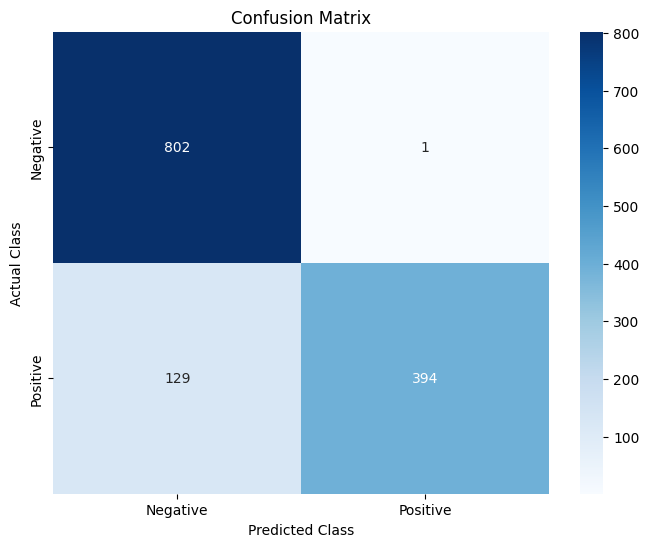

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix (adjust labels for your specific case)
labels = ['Negative', 'Positive']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9019607843137255
Precision: 0.9974683544303797
Recall: 0.7533460803059273
F1 Score: 0.8583877995642701


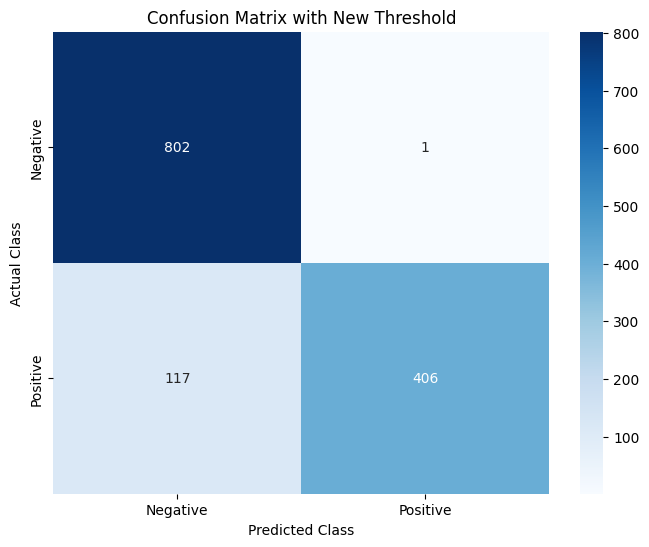

In [21]:
# Example: Adjusting threshold to prioritize recall
new_threshold = 0.4
new_binary_predictions = (predictions > new_threshold).astype(int)
new_conf_matrix = confusion_matrix(y_test, new_binary_predictions)

# Redisplay new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix with New Threshold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

True Negatives (TN): 802
False Positives (FP): 1
False Negatives (FN): 129
True Positives (TP): 394


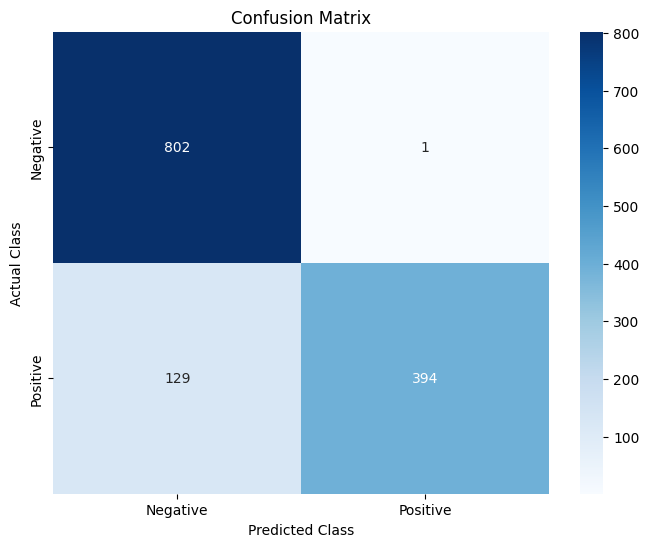

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming binary_predictions and y_test are already defined

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [23]:
print(model.output_shape)

(None, 1)


In [24]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [25]:
X_train_flat = X_train.values
X_test_flat = X_test.values

In [26]:
def model_predict(data):
    reshaped_data = data.reshape(data.shape[0], 1, data.shape[1])
    return model.predict(reshaped_data)

In [27]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_train_flat, 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [28]:
shap_values = explainer.shap_values(X_test_flat[:20], nsamples=100)

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━

In [29]:
# Ensure that single_record_features is correctly shaped
single_record_features = X_test_flat[0]  # This assumes X_test_flat is (samples, features) and already 2D

# Check the shape or length
print("Features length:", len(single_record_features))

# Select SHAP values for a single record, assuming shap_values is a 2D array of shape (100, 16)
single_record_shap_values = shap_values[0]
print("Correctly selected SHAP values length:", len(single_record_shap_values))

Features length: 15
Correctly selected SHAP values length: 20


In [30]:
explainer.expected_value

array([0.38487312])

In [31]:
single_record_features = X_test_flat[0]  # This should be a flat array with the same length as SHAP values
print("Features shape:", single_record_features.shape)

print("SHAP values:", single_record_shap_values)
print("Feature values:", single_record_features)


Features shape: (15,)
SHAP values: [[ 0.          0.          0.09079922 -0.09200366 -0.15667545 -0.03808513
  -0.0727471  -0.10561198  0.          0.07650695  0.         -0.03217078
   0.01261579  0.          0.        ]
 [ 0.01751202  0.          0.05501038  0.07027084  0.07043544  0.14564254
   0.01071107  0.0628663   0.0099146   0.02452538  0.          0.12395729
   0.00869447  0.          0.        ]
 [ 0.          0.         -0.15478913 -0.12882027  0.0522808   0.06562953
   0.          0.          0.         -0.04513952 -0.02810196 -0.07435848
   0.          0.          0.        ]
 [ 0.01671001  0.          0.05095223  0.04681907  0.          0.
   0.12878488  0.32344829 -0.0457027   0.          0.          0.08956906
   0.          0.          0.        ]
 [-0.00817561 -0.02873594 -0.23510016 -0.07218368  0.18611     0.1111394
  -0.03394193 -0.09152307  0.         -0.08180065  0.04493722 -0.0509593
  -0.05652871  0.          0.        ]
 [ 0.         -0.01451546  0.06245319  0

In [32]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [33]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_1.html', shap_html)

In [34]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [35]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_2.html', shap_html)

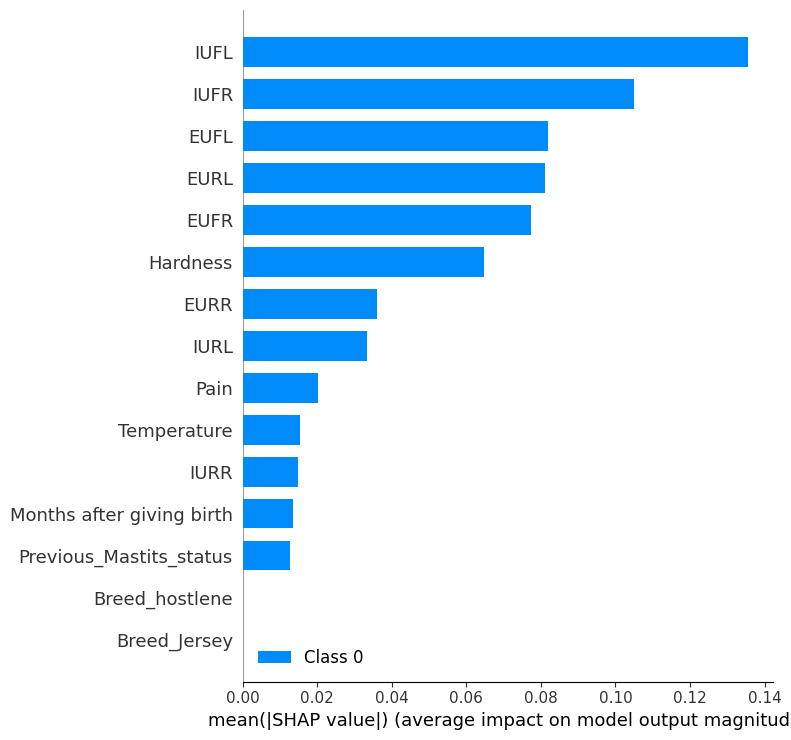

In [36]:
shap.summary_plot(
    shap_values,
    X_test_flat[:100],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15]  # Ensure the feature names list is correctly aligned
)

In [37]:
top_5_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 825 to 1175
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Months after giving birth  5 non-null      int64  
 1   Previous_Mastits_status    5 non-null      int64  
 2   IUFL                       5 non-null      int64  
 3   EUFL                       5 non-null      int64  
 4   IUFR                       5 non-null      int64  
 5   EUFR                       5 non-null      int64  
 6   IURL                       5 non-null      int64  
 7   EURL                       5 non-null      int64  
 8   IURR                       5 non-null      int64  
 9   EURR                       5 non-null      int64  
 10  Temperature                5 non-null      int64  
 11  Hardness                   5 non-null      int64  
 12  Pain                       5 non-null      int64  
 13  Breed_Jersey               5 non-null      int64  
 14

In [38]:
X_sample_test = top_5_predictions.drop(columns=[ 'Predicted Probability','Actual Label'])
X_sample_test

,Months after giving birth,Previous_Mastits_status,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Hardness,Pain,Breed_Jersey,Breed_hostlene
825,3,0,307,362,241,280,233,282,234,275,45,1,0,1,0
560,5,0,242,286,241,287,310,361,246,285,43,0,0,1,0
534,6,0,156,181,337,384,153,183,151,186,45,0,1,1,0
535,6,0,304,354,238,282,240,276,239,274,46,1,1,1,0
1175,3,0,161,185,302,364,157,190,157,189,49,1,1,1,0


In [39]:
Y_sample_test = top_5_predictions['Actual Label'].values
Y_sample_test

array([1, 1, 1, 1, 1])

In [40]:
X_test_flat[:20]

array([[  3,   0, 242, 178, 235, 282, 235, 274, 235, 278,  43,   0,   0,
          1,   0],
       [  4,   0, 224, 263, 293, 345, 223, 265, 225, 265,  43,   1,   0,
          1,   0],
       [  1,   0, 163, 188, 156, 186, 152, 193, 152, 192,  43,   0,   0,
          1,   0],
       [  6,   0, 234, 277, 236, 274, 303, 364, 233, 271,  43,   1,   0,
          1,   0],
       [  4,   0, 157, 181, 157, 189, 156, 182, 155, 185,  43,   0,   0,
          1,   0],
       [  4,   0, 239, 273, 231, 278, 231, 279, 240, 275,  43,   0,   0,
          1,   0],
       [  5,   0, 166, 197, 161, 196, 168, 189, 167, 195,  43,   0,   0,
          1,   0],
       [  5,   0, 160, 192, 153, 189, 158, 186, 152, 191,  43,   0,   0,
          1,   0],
       [  2,   0, 155, 174, 155, 167, 153, 171, 156, 170,  43,   0,   0,
          1,   0],
       [  3,   0, 240, 276, 237, 279, 241, 273, 232, 281,  43,   0,   0,
          1,   0],
       [  1,   0, 234, 279, 304, 355, 242, 272, 243, 280,  48,   1,   1,
       

In [41]:
X_sample_test_flat = X_sample_test.values
X_sample_test_flat

array([[  3,   0, 307, 362, 241, 280, 233, 282, 234, 275,  45,   1,   0,
          1,   0],
       [  5,   0, 242, 286, 241, 287, 310, 361, 246, 285,  43,   0,   0,
          1,   0],
       [  6,   0, 156, 181, 337, 384, 153, 183, 151, 186,  45,   0,   1,
          1,   0],
       [  6,   0, 304, 354, 238, 282, 240, 276, 239, 274,  46,   1,   1,
          1,   0],
       [  3,   0, 161, 185, 302, 364, 157, 190, 157, 189,  49,   1,   1,
          1,   0]])

In [42]:
shap_values_v1 = explainer.shap_values(X_sample_test_flat, nsamples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [43]:
shap_values_v1

[array([[ 0.        ,  0.        ,  0.34110609,  0.24408863, -0.06668487,
         -0.05637684,  0.        ,  0.04431976, -0.03354002,  0.01348887,
         -0.01951355,  0.12570582,  0.01798205,  0.        ,  0.        ],
        [ 0.        ,  0.02571078,  0.04556991,  0.0850553 , -0.11213185,
          0.        ,  0.17976345,  0.41966392,  0.01571459,  0.04312747,
         -0.02611785, -0.07575992,  0.0099547 ,  0.        ,  0.        ],
        [-0.01912556,  0.02731043, -0.04538368, -0.02585769,  0.23308505,
          0.18825706,  0.10401914,  0.10522339,  0.08941327, -0.11843272,
          0.        ,  0.05126025,  0.02524709,  0.        ,  0.        ],
        [ 0.00880299,  0.02180085,  0.31901311,  0.17962939, -0.02527894,
         -0.02176674,  0.        ,  0.        ,  0.        , -0.02652231,
         -0.02909412,  0.11607248,  0.06792288,  0.        ,  0.        ],
        [-0.03118079,  0.        , -0.08564504,  0.03028771,  0.2952285 ,
          0.05784822,  0.09841861,

In [44]:
shap.initjs()
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [45]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_0.html', shap_html)

In [46]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [47]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][1],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_1.html', shap_html)

In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [49]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][2],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_2.html', shap_html)

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [51]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][3],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_3.html', shap_html)

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [53]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][4],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_4.html', shap_html)

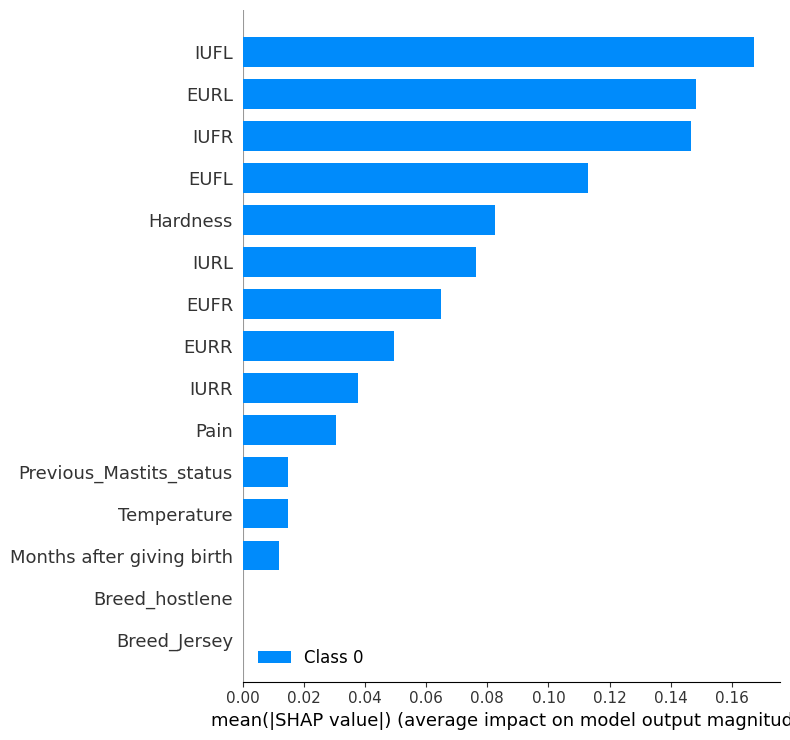

In [54]:
shap.summary_plot(
    shap_values_v1,
    X_sample_test_flat,  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15]  # Ensure the feature names list is correctly aligned
)

In [55]:
shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

In [56]:
shap.plots.force(explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

In [57]:
  shap_html = shap.force_plot(
    explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/top_5_predictions_force_plot_1.html', shap_html)